This is an supervised classification example taken from the KDD 2009 cup.  A copy of the data and details can be found here: [https://github.com/WinVector/PDSwR2/tree/master/KDD2009](https://github.com/WinVector/PDSwR2/tree/master/KDD2009).  The problem was to predict account cancellation ("churn") from very messy data (column names not given, numeric and categorical variables, many missing values, some categorical variables with a large number of possible levels).  In this example we show how to quickly use `vtreat` to prepare the data for modeling.  `vtreat` takes in `Pandas` `DataFrame`s and returns both a treatment plan and a clean `Pandas` `DataFrame` ready for modeling.

Load our packages/modules.

In [1]:
import pandas
import xgboost
import vtreat
import numpy
import numpy.random
import wvpy.util

Read in explanitory variables.

In [2]:


# data from https://github.com/WinVector/PDSwR2/tree/master/KDD2009
dir = "../../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

Read in dependent variable we are trying to predict.

In [3]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [4]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

Arrange test/train split.

In [5]:


n = d.shape[0]
is_train = numpy.random.uniform(size=n)<=0.9
is_test = numpy.logical_not(is_train)

In [6]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Take a look at the dependent variables.  They are a mess, many missing values.  Categorical variables that can not be directly used without some re-encoding.

In [7]:
d_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN
5,NaN,NaN,NaN,NaN,NaN,658.0,7.0,NaN,NaN,NaN,...,zCkv,QqVuch3,LM8l689qOp,NaN,NaN,Qcbd,02N6s8f,Zy3gnGM,am7c,NaN


In [8]:
d_train.shape

(44965, 230)

Try building a model directly off this data (this will fail).

In [9]:
fitter = xgboost.XGBClassifier(n_estimators=10, max_depth=3, objective='binary:logistic')
try:
    fitter.fit(d_train, churn_train)
except Exception as ex:
    print(ex)

DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Var191, Var192, Var193, Var194, Var195, Var196, Var197, Var198, Var199, Var200, Var201, Var202, Var203, Var204, Var205, Var206, Var207, Var208, Var210, Var211, Var212, Var213, Var214, Var215, Var216, Var217, Var218, Var219, Var220, Var221, Var222, Var223, Var224, Var225, Var226, Var227, Var228, Var229


Let's quickly prepare a data frame with none of these issues.

Build our treatment plan, this has the `sklearn.pipeline.Pipeline` interfaces.

In [10]:
plan = vtreat.BinomialOutcomeTreatment(outcome_target=True)

Use `.fit_transform()` to get a special copy of the treated training data that has cross-validated mitigations againsst nested model bias. We call this a "cross frame." `.fit_transform()` is deliberately a different `DataFrame` than what would be returned by `.fit().transform()` (the `.fit().transform()` would damage the modeling effort due nested model bias, the `.fit_transform()` "cross frame" uses cross-validation techniques similar to "stacking" to mitigate these issues).

In [11]:
cross_frame = plan.fit_transform(d_train, churn_train)

Take a look at the new data.  This frame is guaranteed to be all numeric with no missing values.

In [12]:
cross_frame.head()

,Var1_is_bad,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var9_is_bad,Var10_is_bad,Var11_is_bad,...,Var228_logit_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var228_lev_55YFVY9,Var228_lev_ib5G6X1eUxUn6,Var229_logit_code,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.006403,0.653820,1,0,0,-0.017896,0.569198,1,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.041186,0.053664,0,0,1,0.010103,0.233359,0,1,0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,-0.079843,0.653820,1,0,0,0.008275,0.569198,1,0,0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.022627,0.653820,1,0,0,-0.005632,0.195797,0,0,1
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.015539,0.018414,0,0,0,-0.019172,0.233359,0,1,0


In [13]:
cross_frame.shape

(44965, 518)

Pick a recommended subset of the new derived variables.

In [14]:
plan.score_frame_

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
0,Var1_is_bad,missing_indicator,False,0.003385,4.729142e-01,193.0,False
1,Var2_is_bad,missing_indicator,False,0.019442,3.740540e-05,193.0,True
2,Var3_is_bad,missing_indicator,False,0.019410,3.850970e-05,193.0,True
3,Var4_is_bad,missing_indicator,False,0.021402,5.661738e-06,193.0,True
4,Var5_is_bad,missing_indicator,False,0.015501,1.012393e-03,193.0,True
5,Var6_is_bad,missing_indicator,False,-0.032383,6.493446e-12,193.0,True
6,Var7_is_bad,missing_indicator,False,-0.027788,3.781064e-09,193.0,True
7,Var9_is_bad,missing_indicator,False,0.003385,4.729142e-01,193.0,False
8,Var10_is_bad,missing_indicator,False,0.015501,1.012393e-03,193.0,True
9,Var11_is_bad,missing_indicator,False,0.019410,3.850970e-05,193.0,True


In [15]:
model_vars = numpy.asarray(plan.score_frame_["variable"][plan.score_frame_["recommended"]])
len(model_vars)

229

Fit the model

In [16]:
fd = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [17]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.072723,0.000813,0.073457,0.001824
1,0.072712,0.000871,0.073012,0.001685
2,0.072868,0.000888,0.072901,0.001698
3,0.072901,0.000849,0.072901,0.001698
4,0.072912,0.000848,0.072901,0.001698


In [18]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
25,0.071856,0.000892,0.072434,0.001722
77,0.070143,0.000772,0.072434,0.002102


In [19]:
ntree = best.index.values[0]
ntree

25

In [20]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=25,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [21]:
model = fitter.fit(cross_frame.loc[:, model_vars], churn_train)




Apply the data transform to our held-out data.

In [22]:
test_processed = plan.transform(d_test)

Plot the quality of the model score on the held-out data.  This AUC is not great, but in the ballpark of the original contest winners.

In [23]:

pf = pandas.DataFrame({"churn":churn_test})
preds = model.predict_proba(test_processed.loc[:, model_vars])



In [24]:
pf["pred"] = preds[:, 1]

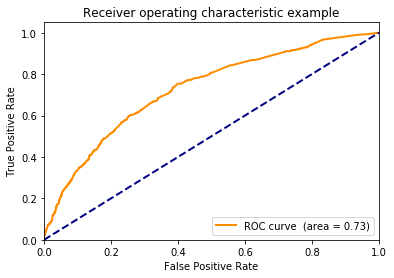

0.7267540362494079

In [25]:
wvpy.util.plot_roc(pf["pred"], pf["churn"])

Notice we dealt with many problem columns at once, and in a statistically sound manner. More on the `vtreat` package for Python can be found here: [https://github.com/WinVector/pyvtreat](https://github.com/WinVector/pyvtreat).  Details on the `R` version can be found here: [https://github.com/WinVector/vtreat](https://github.com/WinVector/vtreat).

Compare to [R solution](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).